# Predict Sale Price 

## Objectives

* Use data cleaning, feature engineering to implement a ML pipeline. 
* Fit, train and evaluate a regression model to predict the sale price of houses in Ames, Iowa. 

## Inputs

* outputs/datasets/collection/house_pices_records.csv
* Instructions on which variables to use for data cleaning and feature engineering that were discovered from previous notebooks. 

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Feature Importance Plot

## CRISP-DM

* This notebook relates to the Modelling and Evaluation step of Crisp-DM methodology


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

# Load Data 

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv"))

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

## ML Pipeline with all Data

### Data Cleaning and Feature Engineering 

In [5]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection


### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature Selection 
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor



def PipelineOptimization(model):
  pipeline_base = Pipeline([

    ### Data Cleaning 
    
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0,
                                variables = ['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF']) ),

    ("CategoricalEncoder",CategoricalImputer(imputation_method='missing',fill_value='Unf',
                                variables = ['BsmtFinType1', 'GarageFinish'])),

    ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                variables = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']) ),  
    ### Feature Engineering 
    ("Ordinalencoder", OrdinalEncoder(encoding_method='arbitrary', 
                          variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']) ),
                          
    ("LogTransformer", vt.LogTransformer(
                         variables = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage']) ),

    ("PowerTransformer", vt.PowerTransformer(
                         variables = ['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'MasVnrArea', 'OpenPorchSF' ]) ),

    ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
                         variables = ['1stFlrSF', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'OpenPorchSF', 'TotalBsmtSF']) ),

    ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                        variables = ['GrLivArea']) ),

      
    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance") ),
    ("feat_scaling",StandardScaler() ),

    ("feat_selection",SelectFromModel(model) ),

    ("model",model ),  
     ])

  return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## ML Pipeline for Modelling and Hyperparameter Optimization 

Custom Class for Hyperparameter Optimization

In [6]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model =  PipelineOptimization(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, )
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


### Split Train and Test Set 

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1168, 23) (1168,) (292, 23) (292,)


## Grid Search CV - Sklearn

We will use standard hyper parameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}



### Quick GridSearch CV - Binary Classifier

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  'r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check results 

In [10]:

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.712432,0.823149,0.875942,0.059815
2,RandomForestRegressor,0.705664,0.794743,0.836984,0.046041
0,LinearRegression,0.745818,0.794282,0.840884,0.034334
5,GradientBoostingRegressor,0.629836,0.773847,0.836809,0.073601
4,AdaBoostRegressor,0.676189,0.755855,0.802705,0.04249
6,XGBRegressor,0.623751,0.696406,0.748881,0.048574
1,DecisionTreeRegressor,0.494971,0.593073,0.725724,0.082569


### Do extensive search on most suitable algorithm to find best hyperparameter configuration

Define model and parameters, for Extensive Search

In [11]:
models_search = {
    "ExtraTreesRegressor":ExtraTreesRegressor(random_state=0),
}

# Documentation used to understand and assist with parameters: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

# n_estimators: int, default=100 
# The number of trees in the forest, which translates to 


# max_depth: int, default=None
# The maximum number 


# min_sample_split: int or float=2
# The minimum number of samples required to split an internal code




params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [100,400],
        'model__max_depth': [2,10,None],
        'model__min_samples_split': [8]
    }
}


Extensive GridSearch CV 

In [12]:

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Check results 

In [13]:

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 


,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
2,ExtraTreesRegressor,0.749918,0.831317,0.882402,0.045503,10,8,100
5,ExtraTreesRegressor,0.741973,0.830236,0.878642,0.048722,None,8,400
4,ExtraTreesRegressor,0.745097,0.829796,0.879722,0.048279,None,8,100
3,ExtraTreesRegressor,0.7451,0.829631,0.879675,0.047649,10,8,400
0,ExtraTreesRegressor,0.642376,0.684044,0.716428,0.029985,2,8,100
1,ExtraTreesRegressor,0.649054,0.683788,0.710188,0.026491,2,8,400


Check best model 

In [14]:

best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 10,
 'model__min_samples_split': 8,
 'model__n_estimators': 100}

Define the best regressor

In [16]:
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea',
                                                   'WoodDeckSF'])),
                ('CategoricalEncoder',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                (...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                  

### Assess Feature Importance 

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea']


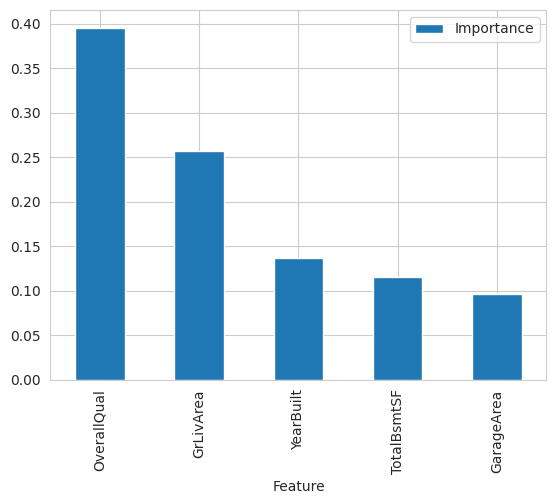

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 9 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[regressor_pipeline['feat_selection'].get_support()],
          'Importance': regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Evaluate performance 

Model Evaluation 

* Train Set
R2 Score: 0.933
Mean Absolute Error: 13830.156
Mean Squared Error: 410700944.017
Root Mean Squared Error: 20265.758


* Test Set
R2 Score: 0.839
Mean Absolute Error: 19841.304
Mean Squared Error: 1112946855.577
Root Mean Squared Error: 33360.858




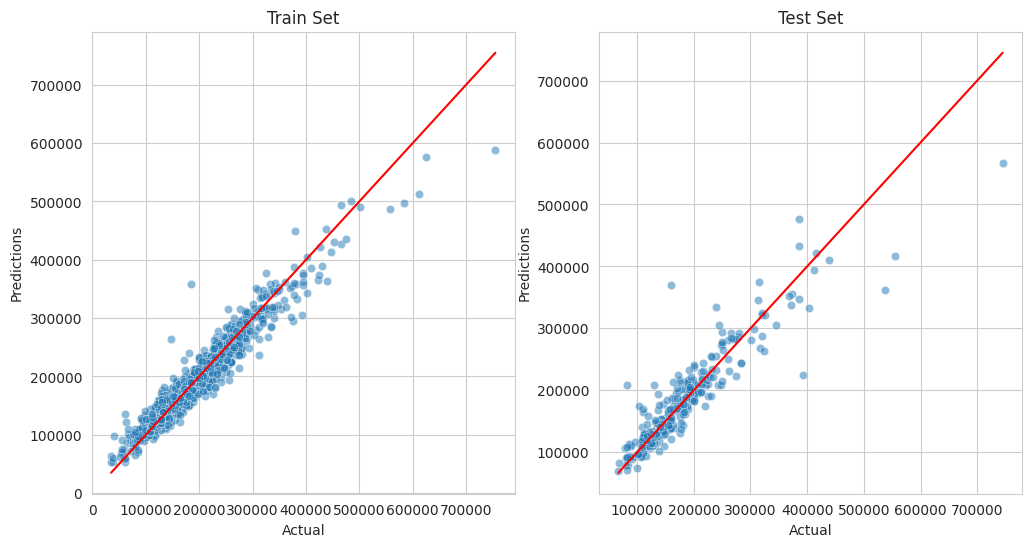

In [19]:

regression_performance(X_train, y_train, X_test, y_test,regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, regressor_pipeline)


Evaluate classifier

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")


def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

### Regressor with PCA

In [21]:

pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:9])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 21) 
 <class 'pandas.core.frame.DataFrame'>


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Apply PCA separately to the scaled data

* The 21 components explain 100.0% of the data 



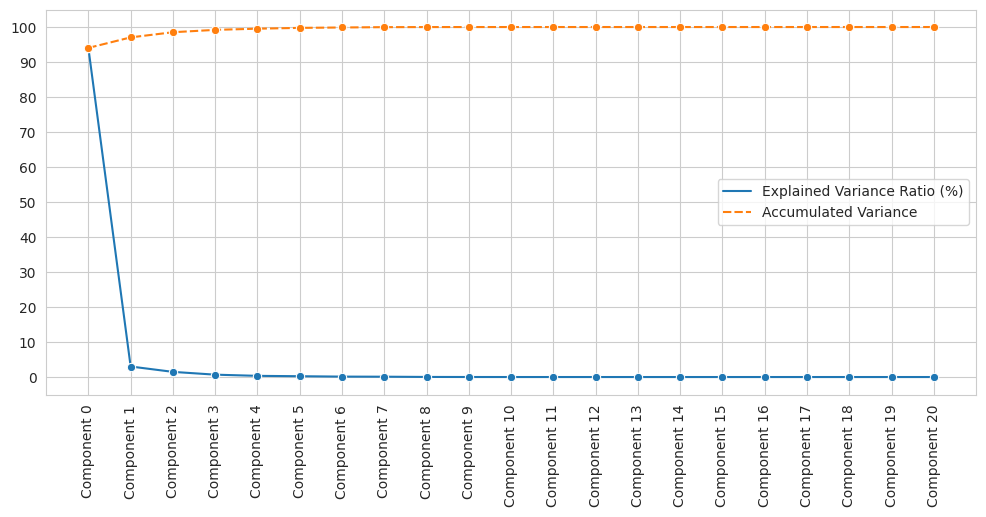

In [22]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 21

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)


* The 4 components explain 99.19% of the data 



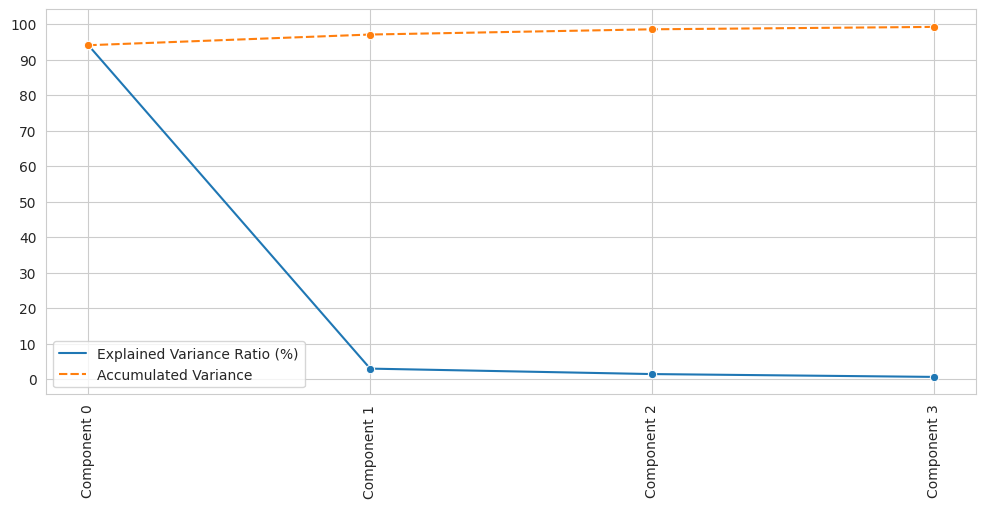

In [23]:

n_components = 4
pca_components_analysis(df_pca=df_pca,n_components=n_components)

### Rewrite ML Pipeline for Regression PCA Model

In [24]:
### PCA
from sklearn.decomposition import PCA

def PipelineOptimization(model):
  pipeline_base = Pipeline([

    ### Data Cleaning 
    
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0,
                                variables = ['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF']) ),

    ("CategoricalEncoder",CategoricalImputer(imputation_method='missing',fill_value='Unf',
                                variables = ['BsmtFinType1', 'GarageFinish'])),

    ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                variables = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']) ),  
    ### Feature Engineering 
    ("Ordinalencoder", OrdinalEncoder(encoding_method='arbitrary', 
                          variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']) ),
                          
    ("LogTransformer", vt.LogTransformer(
                         variables = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage']) ),

    ("PowerTransformer", vt.PowerTransformer(
                         variables = ['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'MasVnrArea', 'OpenPorchSF' ]) ),

    ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
                         variables = ['1stFlrSF', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'OpenPorchSF', 'TotalBsmtSF']) ),

    ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                        variables = ['GrLivArea']) ),

      
    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance") ),
    ("feat_scaling",StandardScaler() ),

    ("feat_selection",SelectFromModel(model) ),

    ("model",model ),  
     ])

  return pipeline_base

### Grid Search CV – Sklearn

In [25]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Use standard hyperparameters to find most suitable model

In [26]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a quick optimization search

In [27]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check results

In [28]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.712432,0.823149,0.875942,0.059815
2,RandomForestRegressor,0.705664,0.794743,0.836984,0.046041
0,LinearRegression,0.745818,0.794282,0.840884,0.034334
5,GradientBoostingRegressor,0.629836,0.773847,0.836809,0.073601
4,AdaBoostRegressor,0.676189,0.755855,0.802705,0.04249
6,XGBRegressor,0.623751,0.696406,0.748881,0.048574
1,DecisionTreeRegressor,0.494971,0.593073,0.725724,0.082569


Define the best regressor

In [29]:

regressor_pipeline

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea',
                                                   'WoodDeckSF'])),
                ('CategoricalEncoder',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                (...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                  

### Refit pipeline with best features

Rewrite ML pipeline for Data Cleaning, Feature Engineering and Modeling

In [30]:

best_features

['GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']

In [63]:
### ADD BEST FEATURES TO ONLY TO PIPELINE


# Pipeline Optmization: Model
def PipelineOptimization(model):
  pipeline_base = Pipeline([
     
    ### Feature Engineering 
                          
    ("LogTransformer", vt.LogTransformer(
                         variables = ['GrLivArea']) ),

    ("PowerTransformer", vt.PowerTransformer(
                         variables = ['GarageArea', 'GrLivArea']) ),

    ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
                         variables = ['GarageArea', 'GrLivArea']) ),

    ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                        variables = ['GrLivArea']) ),
     
     ("scaler",StandardScaler()),
       
     # no feature selection needed anymore!!! We know which features to use already!
     
     ("model",model ),
     
  ])

  return pipeline_base 

Then filter using the best features

### Split Train and Test sets with only the best features

In [64]:

from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


In [65]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 5) (1168,) (292, 5) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921


### Grid Search CV - SKLearn

In [66]:

models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [67]:
best_parameters

{'model__max_depth': 10,
 'model__min_samples_split': 8,
 'model__n_estimators': 100}

In [68]:

params_search = {'ExtraTreesRegressor':  {
    'model__max_depth': [10], 
    'model__min_samples_split': [8],
    'model__n_estimators': [100],        
}
}
params_search

{'ExtraTreesRegressor': {'model__max_depth': [10],
  'model__min_samples_split': [8],
  'model__n_estimators': [100]}}

In [69]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = 'r2',
           n_jobs=-1,cv=5)



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Chech results

In [70]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.742359,0.831692,0.878885,0.047848,10,8,100


Check the Best Model

In [71]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Define the best regression pipeline

In [72]:
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['GarageArea', 'GrLivArea'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GarageArea', 'GrLivArea'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_split=8,
                                     random_state=0))])

### Assess Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageArea', 'TotalBsmtSF']


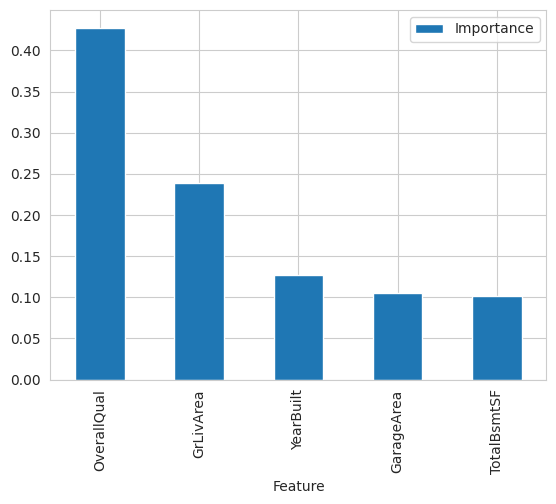

In [73]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
                        'Feature': best_features,
                        'Importance': regressor_pipeline['model'].feature_importances_})
                    .sort_values(by='Importance', ascending=False)
        )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [74]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_saleprice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_saleprice/v1'


### Train Set: Features and Target

In [75]:
print(X_train.shape)
X_train.head()

(1168, 5)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921
817,857,1689,8,1568,2002
302,843,1541,7,1541,2001


In [76]:

X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [77]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [78]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: Features and Target

In [79]:
print(X_test.shape)
X_test.head()


(292, 5)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
529,484,2515,6,2035,1957
491,240,1578,6,806,1941
459,352,1203,5,709,1950
279,505,2022,7,1160,1977
655,264,1092,6,525,1971


In [80]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [81]:

y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [82]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling Pipeline 

In [83]:

regressor_pipeline


Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['GarageArea', 'GrLivArea'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GarageArea', 'GrLivArea'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_split=8,
                                     random_state=0))])

In [84]:
import joblib
joblib.dump(value=regressor_pipeline, filename=f"{file_path}/regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_saleprice/v1/regressor_pipeline.pkl']

### Feature Importance Plot 

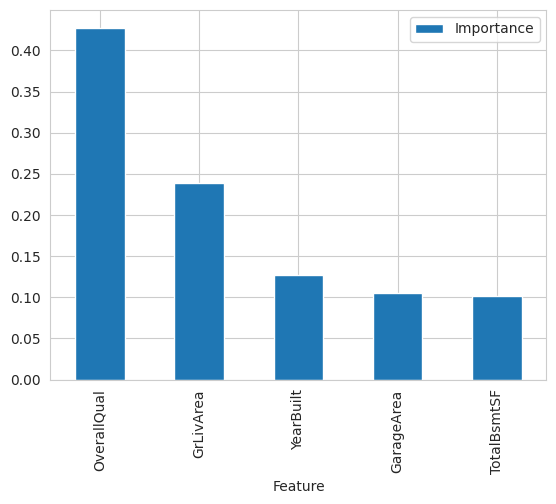

In [85]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

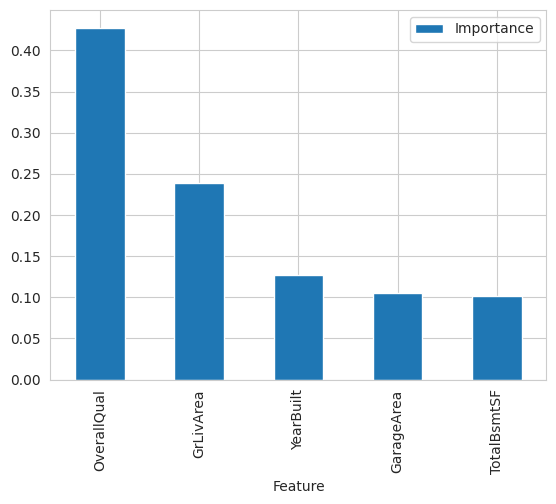

In [86]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

# Conclusion